In [94]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
# hack the paths, no package install needed
import sys
import os
repo_dir = '/media/user/repos/bulk-euclid-cutouts'
os.path.isdir(repo_dir)
sys.path.insert(0,repo_dir)

In [96]:
import logging
logging.basicConfig(level=logging.INFO)
import os

import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import pandas as pd

from bulk_euclid.external_targets import pipeline

### Set Pipeline Options and Load External Targets

In [97]:
# you can use this config and external target list for a minimal test on six targets within one tile...

cfg_dict = dict(
    # TODO change this path to wherever you want to save everything
    base_dir='/media/home/my_workspace/repos/bulk-euclid-cutouts/tests/test_external_targets/test_notebook_version',
    name='external_targets_debug',

    sas_environment='IDR', # for Q1, REG for Regression, or OTF for On-The-Fly
    release_name=None, # for no specific release or e.g. 'F-006' for one release 
    release_priority=['CALBLOCK_PV-005_R2', 'CALBLOCK_PV-005_R3', 'F-003_240321', 'F-003_240612' , 'F-006', 'Q1_R1'],  # use the highest-index release first, if available
    bands=['VIS', 'NIR_Y'], # bands to use, can also have NIR_J, NIR_H. Include all bands you need for cutouts.
    auxillary_products=['MERPSF','MERRMS'],  # can also use MERBKG for background

    download_method='datalabs_path',  # to use datalabs data (Q1 only) or 'sas' for download
    delete_tiles=False,  # if 'sas', delete tiles after downloading them. No effect on when using 'datalabs_path'
    fits_outputs=True,  # make FITS
    jpg_outputs=['sw_mtf_vis_only', 'sw_mtf_vis_y', 'sw_arcsinh_vis_only'],  # three example processing options, see cutout_utils.py for more options. Set False for no jpg cutouts.
    jpg_quality=95,  # jpg compression strength. lower quality is much smaller but gets 'fuzzier'. See PIL.Image docs. 
    use_fits_origin_for_jpg=True,  # orient the jpg the same way up as the FITS standard
    overwrite_fits=False,  # if fits already exists, overwrite them with new cutouts
    overwrite_jpg=False,  # similarly for jpg

    # these will be filled in automatically using on base_dir
    download_dir=None,
    tile_dir=None,
    cutout_dir=None,
    fits_dir=None,
    jpg_dir=None,
    sanity_dir=None
)
cfg = OmegaConf.create(cfg_dict)  # easy to access with cfg.base_dir, etc
pipeline.create_folders(cfg)  # fill in those missing paths

external_targets = pd.DataFrame([
# replace with your own dataframe, e.g. pd.read_csv('my_external_targets)
    {
        'id_str': 'a',
        'target_ra': 53.562126,
        'target_dec': -28.012906,
        'target_field_of_view': 10,
        'category': 'cool_strong_lens'  # any name you like, will be used for subfolders
    },
    {
        'id_str': 'b',
        'target_ra': 270.9980283,
        'target_dec': 65.65370217,
        'target_field_of_view': 10,
        'category': 'cool_strong_lens' 
    }
])

INFO:root:Saving to /media/home/my_workspace/repos/bulk-euclid-cutouts/tests/test_external_targets/test_notebook_version/external_targets_debug


In [98]:
cfg.jpg_outputs

['sw_mtf_vis_only', 'sw_mtf_vis_y', 'sw_arcsinh_vis_only']

In [99]:
len(cfg.bands)

2

In [100]:
len(external_targets)

2

In [101]:
assert not any(external_targets['id_str'].duplicated())

In [102]:
external_targets

,id_str,target_ra,target_dec,target_field_of_view,category
0,a,53.562126,-28.012906,10,cool_strong_lens
1,b,270.998028,65.653702,10,cool_strong_lens


### Authenticate

In [103]:
# # type in your COSMOS credentials
# from astroquery.esa.euclid.core import EuclidClass
# Euclid = EuclidClass(environment=cfg.sas_environment)
# Euclid.login()

# the code below is a shorthand version for the above
# it adds Euclid to Python's globals, which saves passing it around all the time
from bulk_euclid.utils import pipeline_utils
pipeline_utils.login(cfg)

INFO:astroquery:Login to Euclid TAP server


INFO: Login to Euclid TAP server [astroquery.esa.euclid.core]


User:  mwalms01
Password:  ········


INFO:astroquery:OK
INFO:astroquery:Login to Euclid data service
INFO:astroquery:OK
INFO:astroquery:Login to Euclid cutout service


INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid data service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid cutout service [astroquery.esa.euclid.core]


INFO:astroquery:OK


INFO: OK [astroquery.utils.tap.core]


### For each target, find a tile that covers it

In [104]:
targets_with_tiles = pipeline.get_matching_tiles(cfg, external_targets)
targets_with_tiles

INFO:astroquery:Query finished.
INFO:root:Found 352 query results
INFO:root:release_name
Q1_R1    352
Name: count, dtype: int64
INFO:root:Begin target/tile cross-match
INFO:root:Matched 2 targets to 2 tiles
INFO:root:Targets with tile matches: 2


INFO: Query finished. [astroquery.utils.tap.core]


,id_str,target_ra,target_dec,target_field_of_view,category,tile_index,release_name,tile_ra,tile_ra_min,tile_ra_max,tile_dec_min,tile_dec_max,tile_dec
0,a,53.562126,-28.012906,10,cool_strong_lens,102044186,Q1_R1,53.550643,53.247877,53.853376,-28.266303,-27.733009,-28.0
1,b,270.998028,65.653702,10,cool_strong_lens,102158892,Q1_R1,270.930081,270.280429,271.579666,65.232018,65.765286,65.5


In [105]:
targets_with_tiles['release_name'].value_counts()

release_name
Q1_R1    2
Name: count, dtype: int64

In [106]:
targets_with_tiles = targets_with_tiles.sort_values('tile_index')[:1000]

The speed of the pipeline depends on the number of tiles to download. It takes about 30 seconds per tile, per band, per product. If you request two bands and four products (as above), each tile takes about 4 minutes.

In [107]:
targets_with_tiles['tile_index'].nunique()

2

### For every tile, download the flux and auxillary (PSF, RMS, BKG) data and make cutouts around each target in that tile

In [108]:
pipeline.make_cutouts(cfg, targets_with_tiles)

INFO:root:Tile 102044186, 0 of 2
INFO:astroquery:Query finished.
INFO:root:Found 2 query results
INFO:root:Downloading all data for tile 102044186


INFO: Query finished. [astroquery.utils.tap.core]


INFO:root:Downloaded all data for tile 102044186
INFO:root:Loaded tile, ready to slice
INFO:root:Cutout data sliced for band VIS
INFO:root:Loaded tile, ready to slice
INFO:root:Cutout data sliced for band NIR_Y
INFO:root:Cutout data sliced for all bands, begin saving to disk
INFO:root:Saved cutouts for all targets in tile 102044186
INFO:root:Tile 102158892, 1 of 2
INFO:astroquery:Query finished.
INFO:root:Found 2 query results
INFO:root:Downloading all data for tile 102158892
INFO:root:Downloaded all data for tile 102158892


INFO: Query finished. [astroquery.utils.tap.core]


INFO:root:Loaded tile, ready to slice
INFO:root:Cutout data sliced for band VIS
INFO:root:Loaded tile, ready to slice
INFO:root:Cutout data sliced for band NIR_Y
INFO:root:Cutout data sliced for all bands, begin saving to disk
INFO:root:Saved cutouts for all targets in tile 102158892


In [109]:
import glob
from PIL import Image

jpg_locs = glob.glob(os.path.join(cfg.jpg_dir, 'cool_strong_lens/*/*.jpg'))
jpg_locs

['/media/home/my_workspace/repos/bulk-euclid-cutouts/tests/test_external_targets/test_notebook_version/external_targets_debug/cutouts/jpg/cool_strong_lens/sw_arcsinh_vis_only/a_sw_arcsinh_vis_only.jpg',
 '/media/home/my_workspace/repos/bulk-euclid-cutouts/tests/test_external_targets/test_notebook_version/external_targets_debug/cutouts/jpg/cool_strong_lens/sw_arcsinh_vis_only/b_sw_arcsinh_vis_only.jpg',
 '/media/home/my_workspace/repos/bulk-euclid-cutouts/tests/test_external_targets/test_notebook_version/external_targets_debug/cutouts/jpg/cool_strong_lens/sw_mtf_vis_only/a_sw_mtf_vis_only.jpg',
 '/media/home/my_workspace/repos/bulk-euclid-cutouts/tests/test_external_targets/test_notebook_version/external_targets_debug/cutouts/jpg/cool_strong_lens/sw_mtf_vis_only/b_sw_mtf_vis_only.jpg',
 '/media/home/my_workspace/repos/bulk-euclid-cutouts/tests/test_external_targets/test_notebook_version/external_targets_debug/cutouts/jpg/cool_strong_lens/sw_mtf_vis_y/a_sw_mtf_vis_y.jpg',
 '/media/home/m

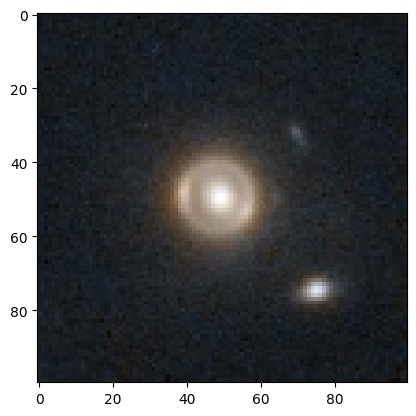

In [110]:
loc = jpg_locs[4]  # for example
plt.imshow(Image.open(loc))